<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [37]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [38]:
# Load the data
house = pd.read_csv('./housing.csv')

In [39]:
house.shape

(1460, 81)

In [145]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 76 columns):
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1385 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
OverallQual      1385 non-null int64
OverallCond      1385 non-null int64
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non-null object
Exterior2nd      1385 non-null object
MasVnrType       1385 no

In [41]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [42]:
# Removing non-residential dwellings from the dataset
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [43]:
residential = ['RH', 'RL', 'RP', 'RM']
house = house[house['MSZoning'].isin(residential)]

In [44]:
house.MSZoning.value_counts()

RL    1151
RM     218
RH      16
Name: MSZoning, dtype: int64

In [45]:
# Checking for null values in the data
null_values = house.columns[house.isnull().sum()>0]
house.isnull().sum()[list(null_values)].sort_values(ascending=False)

PoolQC          1378
MiscFeature     1333
Alley           1320
Fence           1108
FireplaceQu      641
LotFrontage      251
GarageYrBlt       79
GarageType        79
GarageFinish      79
GarageQual        79
GarageCond        79
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         5
MasVnrType         5
Electrical         1
dtype: int64

In [46]:
# Dropping these columns as they have too many null values
house.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1,inplace=True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
house.columns

Index([u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea', u'Street',
       u'LotShape', u'LandContour', u'Utilities', u'LotConfig', u'LandSlope',
       u'Neighborhood', u'Condition1', u'Condition2', u'BldgType',
       u'HouseStyle', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'RoofStyle', u'RoofMatl', u'Exterior1st',
       u'Exterior2nd', u'MasVnrType', u'MasVnrArea', u'ExterQual',
       u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond', u'BsmtExposure',
       u'BsmtFinType1', u'BsmtFinSF1', u'BsmtFinType2', u'BsmtFinSF2',
       u'BsmtUnfSF', u'TotalBsmtSF', u'Heating', u'HeatingQC', u'CentralAir',
       u'Electrical', u'1stFlrSF', u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea',
       u'BsmtFullBath', u'BsmtHalfBath', u'FullBath', u'HalfBath',
       u'BedroomAbvGr', u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd',
       u'Functional', u'Fireplaces', u'FireplaceQu', u'GarageType',
       u'GarageYrBlt', u'GarageFinish', u'GarageCars', u'Garage

In [50]:
# Replacing null values with values 
house['FireplaceQu']=house['FireplaceQu'].fillna('No_Fireplce')
house['LotFrontage'].fillna(house['LotFrontage'].median(),inplace=True)
house['GarageYrBlt'].fillna(house['YearBuilt'],inplace=True)
house['GarageType']=house['GarageType'].fillna('No_Garage')
house['GarageFinish']=house['GarageFinish'].fillna('No_Garage')
house['GarageQual']=house['GarageQual'].fillna('No_Garage')
house['GarageCond']=house['GarageCond'].fillna('No_Garage')
house['BsmtQual']=house['BsmtQual'].fillna('No_Bsmt')
house['BsmtCond']=house['BsmtCond'].fillna('No_Bsmt')
house['BsmtExposure']=house['BsmtExposure'].fillna('No_Bsmt') 
house['BsmtFinType1']=house['BsmtFinType1'].fillna('No_Bsmt') 
house['BsmtFinType2']=house['BsmtFinType2'].fillna('No_Bsmt') 
house['MasVnrType'].fillna('None',inplace=True)
house['Electrical'].fillna('None',inplace=True)
house['MasVnrArea'].fillna(value = 0,inplace=True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [146]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 76 columns):
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1385 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
OverallQual      1385 non-null int64
OverallCond      1385 non-null int64
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non-null object
Exterior2nd      1385 non-null object
MasVnrType       1385 no

In [147]:
# Checking to see if any null values remain
null_values = house.columns[house.isnull().sum()>0]
house.isnull().sum()[list(null_values)].sort_values(ascending=False)

Series([], dtype: int64)

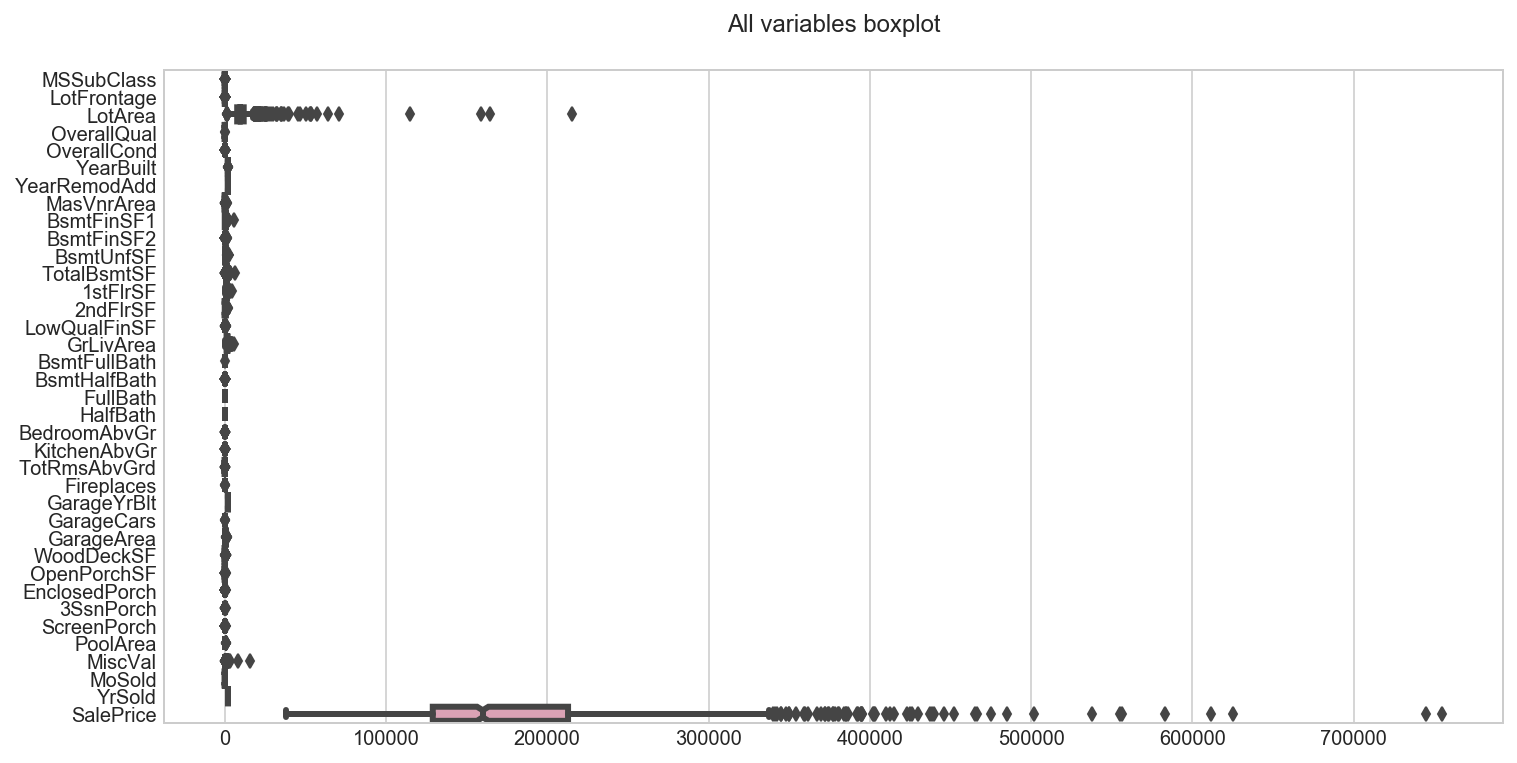

In [55]:
# Some EDA plotting
fig = plt.figure(figsize=(12,6))
ax = fig.gca()

ax = sns.boxplot(data=house, orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('All variables boxplot\n')
plt.show()

In [56]:
house.corr()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.325074,-0.116667,0.010631,-0.046885,-0.008138,0.005391,-0.002098,-0.068126,-0.058497,...,0.009493,-0.021825,0.002317,-0.041987,-0.021542,0.011508,-0.004150,0.001817,-0.015370,-0.085592
LotFrontage,-0.325074,1.000000,0.296498,0.259875,-0.062985,0.146689,0.104035,0.213242,0.224754,0.038805,...,0.064670,0.164747,0.004258,0.061863,0.034635,0.185006,-0.002437,-0.001160,0.000353,0.339647
LotArea,-0.116667,0.296498,1.000000,0.120835,-0.015650,0.033334,0.030755,0.119789,0.216267,0.106581,...,0.165826,0.105439,-0.023609,0.018334,0.039761,0.076847,0.036094,-0.002413,-0.014925,0.270955
OverallQual,0.010631,0.259875,0.120835,1.000000,-0.091828,0.554148,0.531796,0.441730,0.249765,-0.053523,...,0.246601,0.309383,-0.093632,0.034527,0.073138,0.069224,-0.028311,0.078726,-0.027897,0.790986
OverallCond,-0.046885,-0.062985,-0.015650,-0.091828,1.000000,-0.378201,0.092515,-0.134440,-0.059566,0.032316,...,-0.015622,-0.013363,0.071620,0.022431,0.048815,-0.004058,0.068407,0.002987,0.048508,-0.081196
YearBuilt,-0.008138,0.146689,0.033334,0.554148,-0.378201,1.000000,0.568667,0.333540,0.274446,-0.039017,...,0.245222,0.162588,-0.374592,0.037492,-0.041015,0.008031,-0.031099,0.017647,-0.011708,0.517466
YearRemodAdd,0.005391,0.104035,0.030755,0.531796,0.092515,0.568667,1.000000,0.186772,0.141211,-0.059275,...,0.222395,0.208881,-0.175566,0.051049,-0.032639,0.008568,-0.005911,0.023294,0.039921,0.499208
MasVnrArea,-0.002098,0.213242,0.119789,0.441730,-0.134440,0.333540,0.186772,1.000000,0.272919,-0.074942,...,0.177869,0.169534,-0.111205,0.020898,0.047013,0.013002,-0.030577,-0.005096,-0.008038,0.508017
BsmtFinSF1,-0.068126,0.224754,0.216267,0.249765,-0.059566,0.274446,0.141211,0.272919,1.000000,-0.055769,...,0.205756,0.135922,-0.105140,0.025153,0.056660,0.142202,0.003120,-0.013594,0.011764,0.394510
BsmtFinSF2,-0.058497,0.038805,0.106581,-0.053523,0.032316,-0.039017,-0.059275,-0.074942,-0.055769,1.000000,...,0.063475,0.016376,0.034191,-0.031896,0.086503,0.040733,0.003838,-0.014835,0.033761,-0.008722


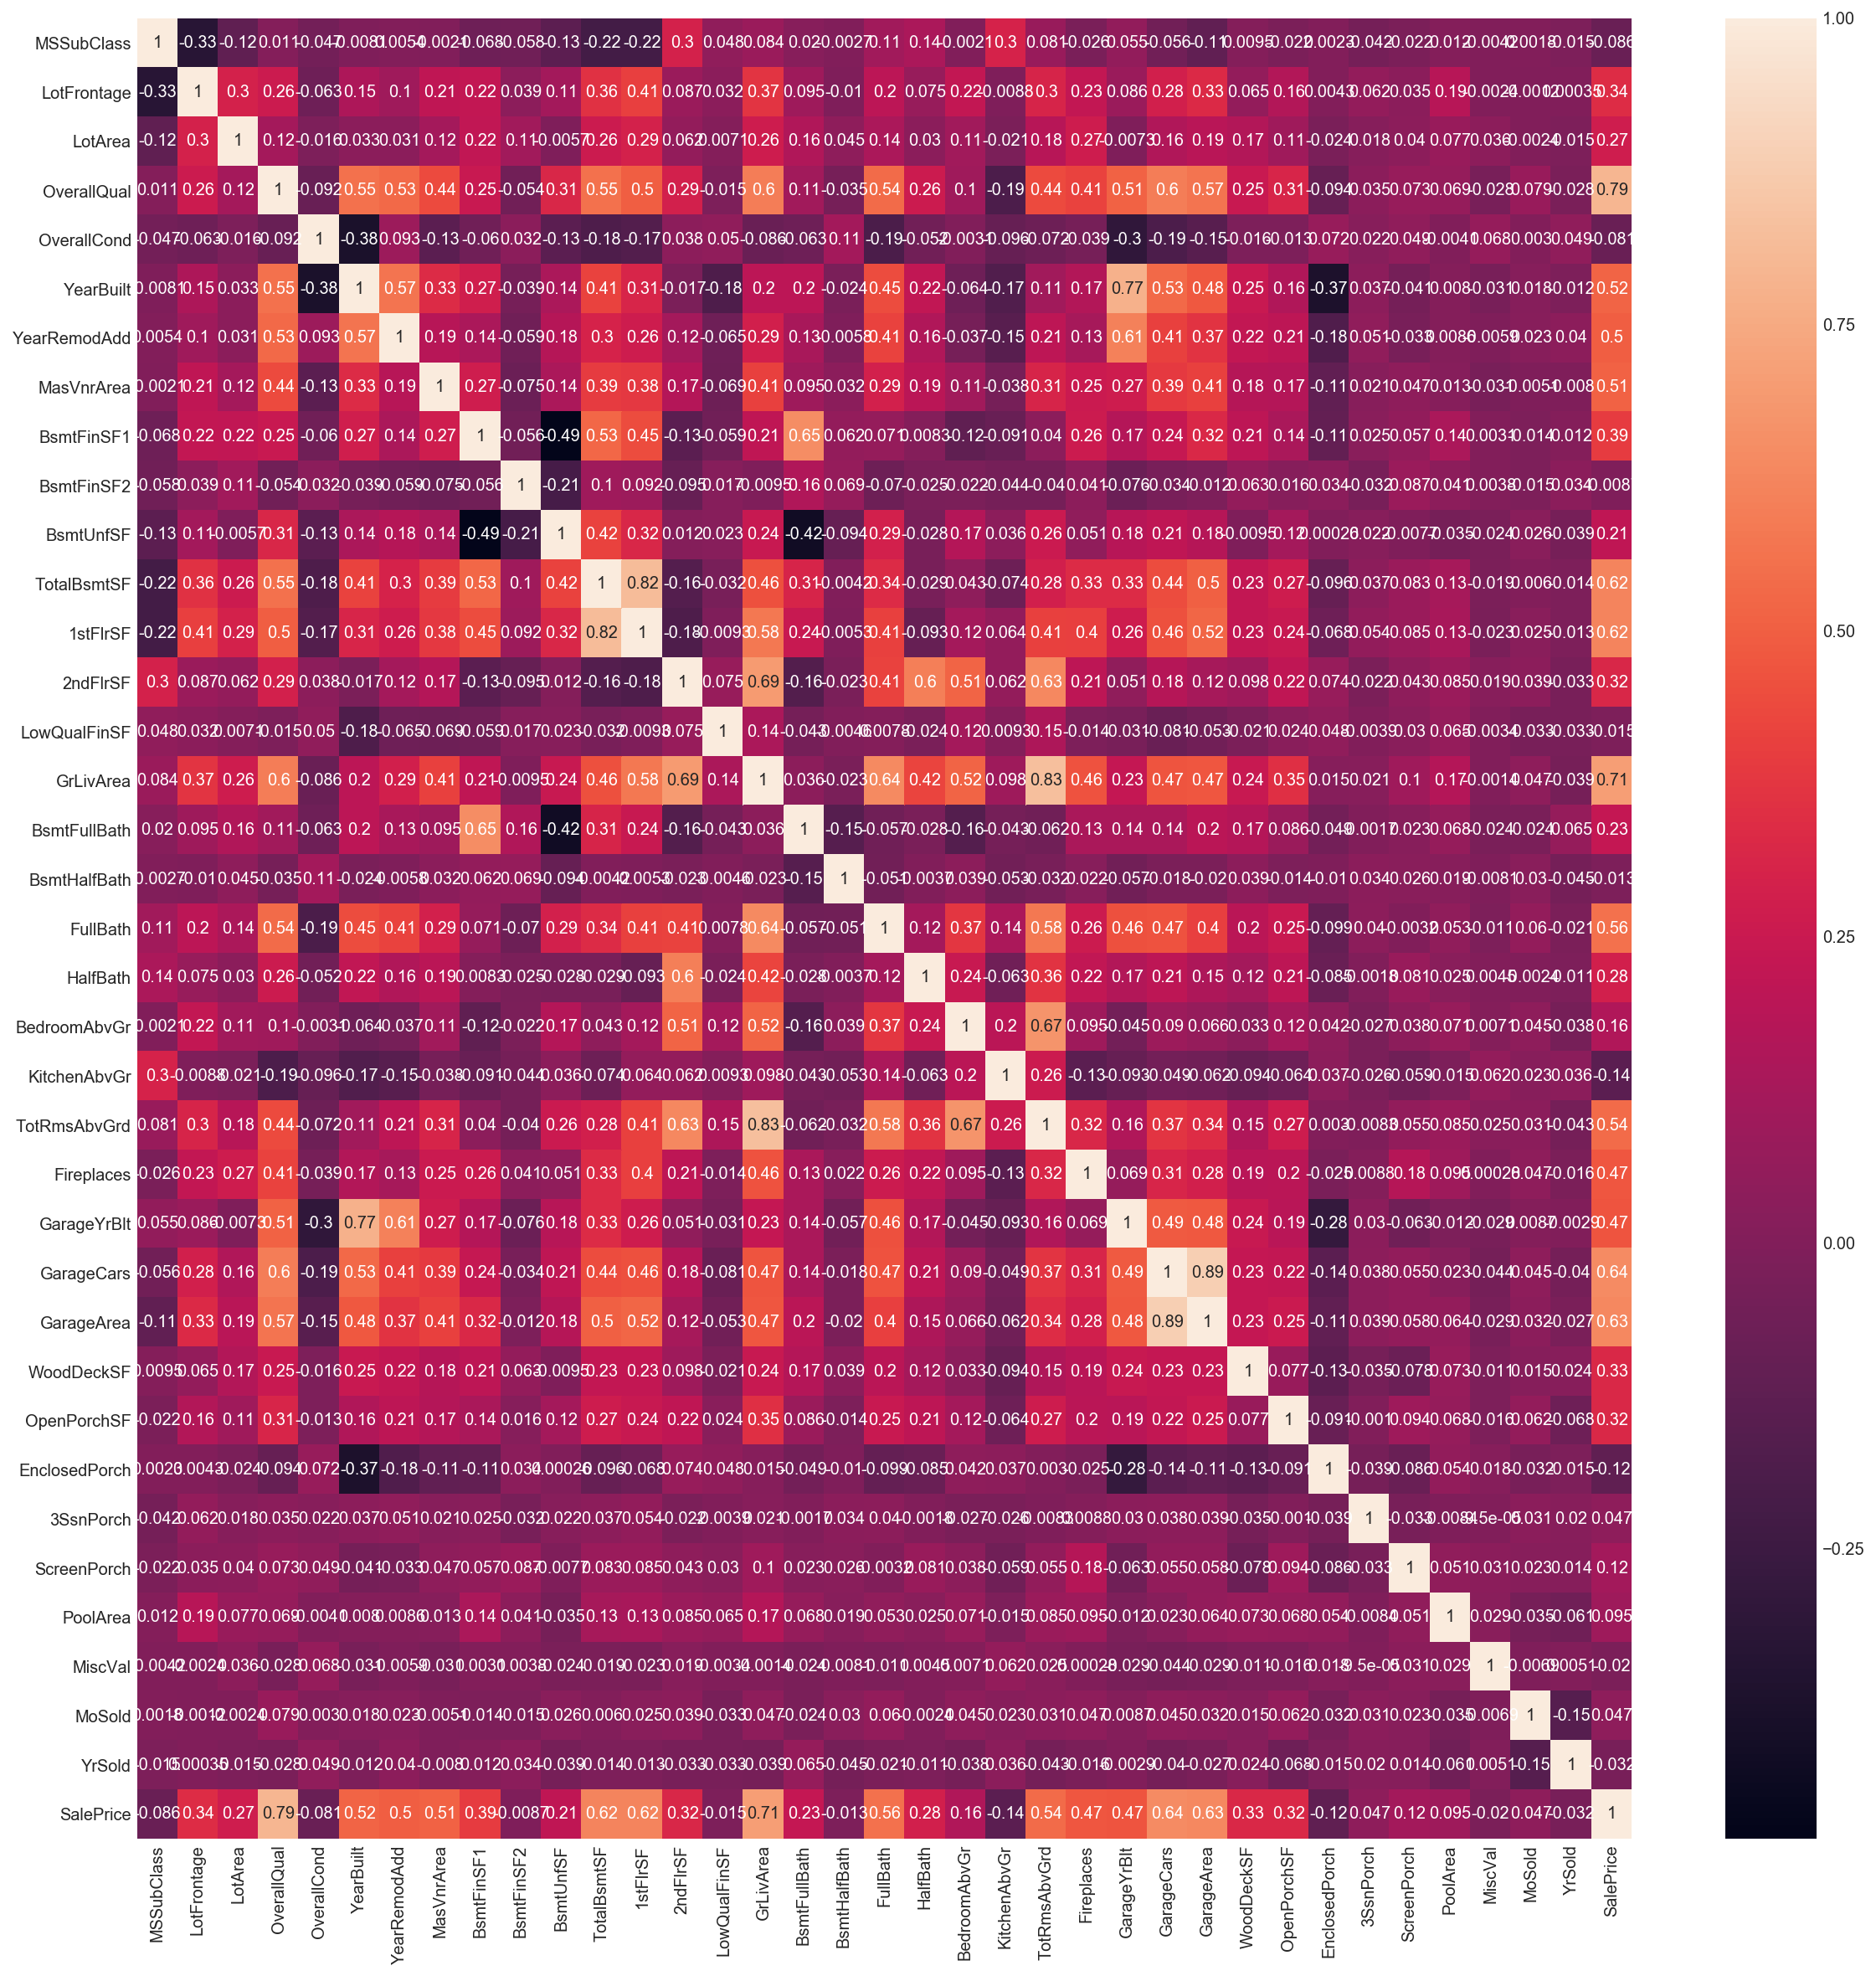

In [57]:
# Heatmap to see correlation between variables
plt.figure(figsize=(20,20))
sns.heatmap(house.corr(), annot=True)

In [58]:
# Variable of interest
house['SalePrice'].describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

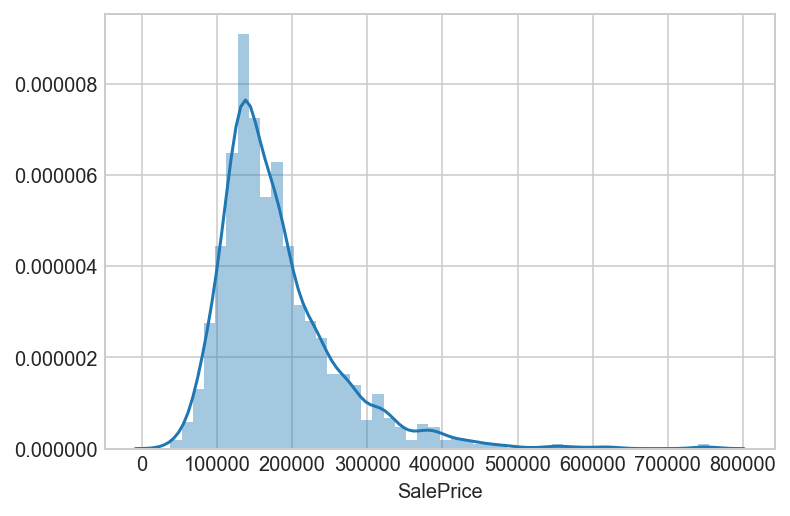

In [59]:
sns.distplot(house['SalePrice'])

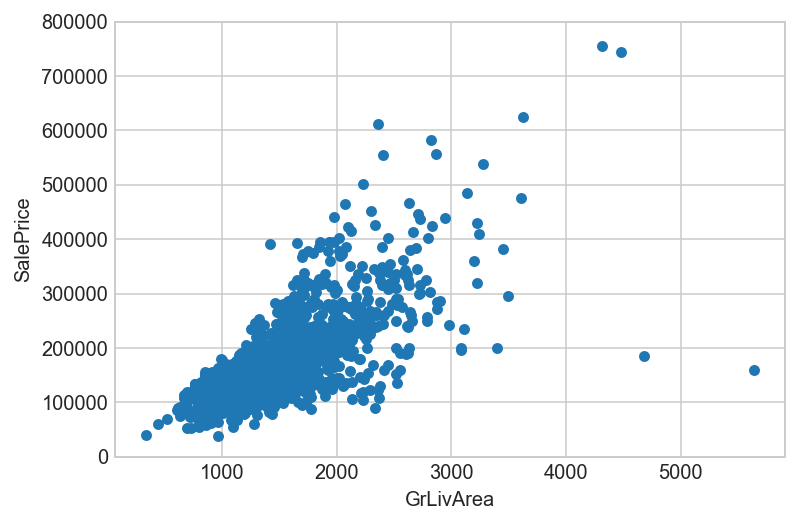

In [60]:
var = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

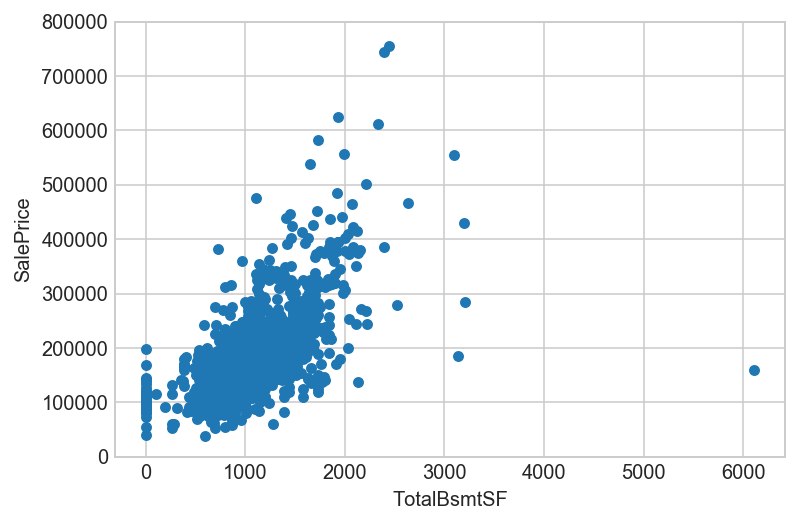

In [61]:
var = 'TotalBsmtSF'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

(-0.5, 9.5, 0, 800000)

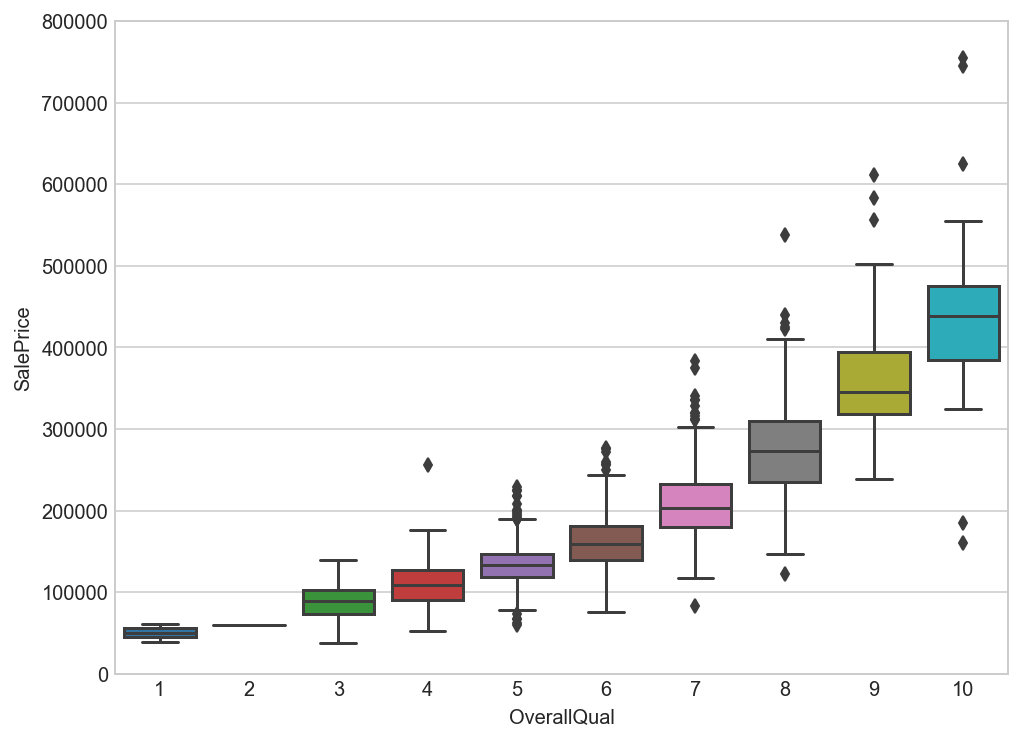

In [64]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

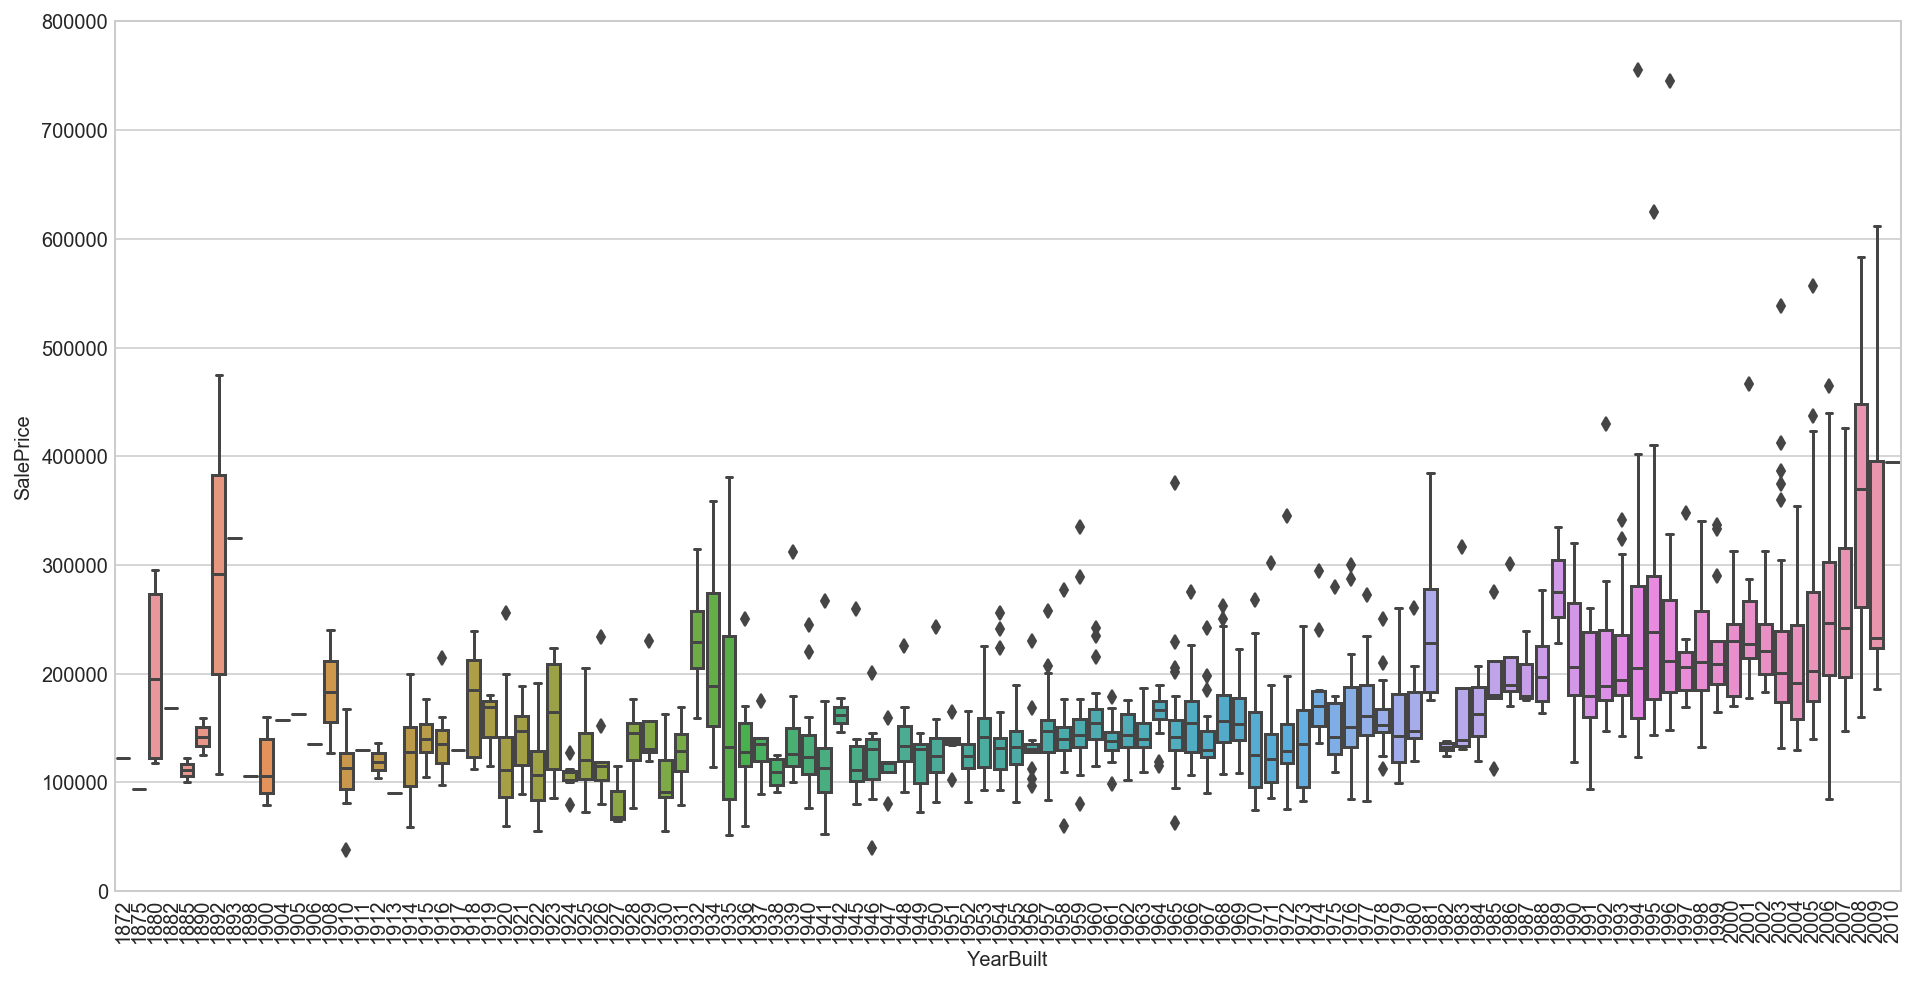

In [65]:
# More EDA
var = 'YearBuilt'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90)

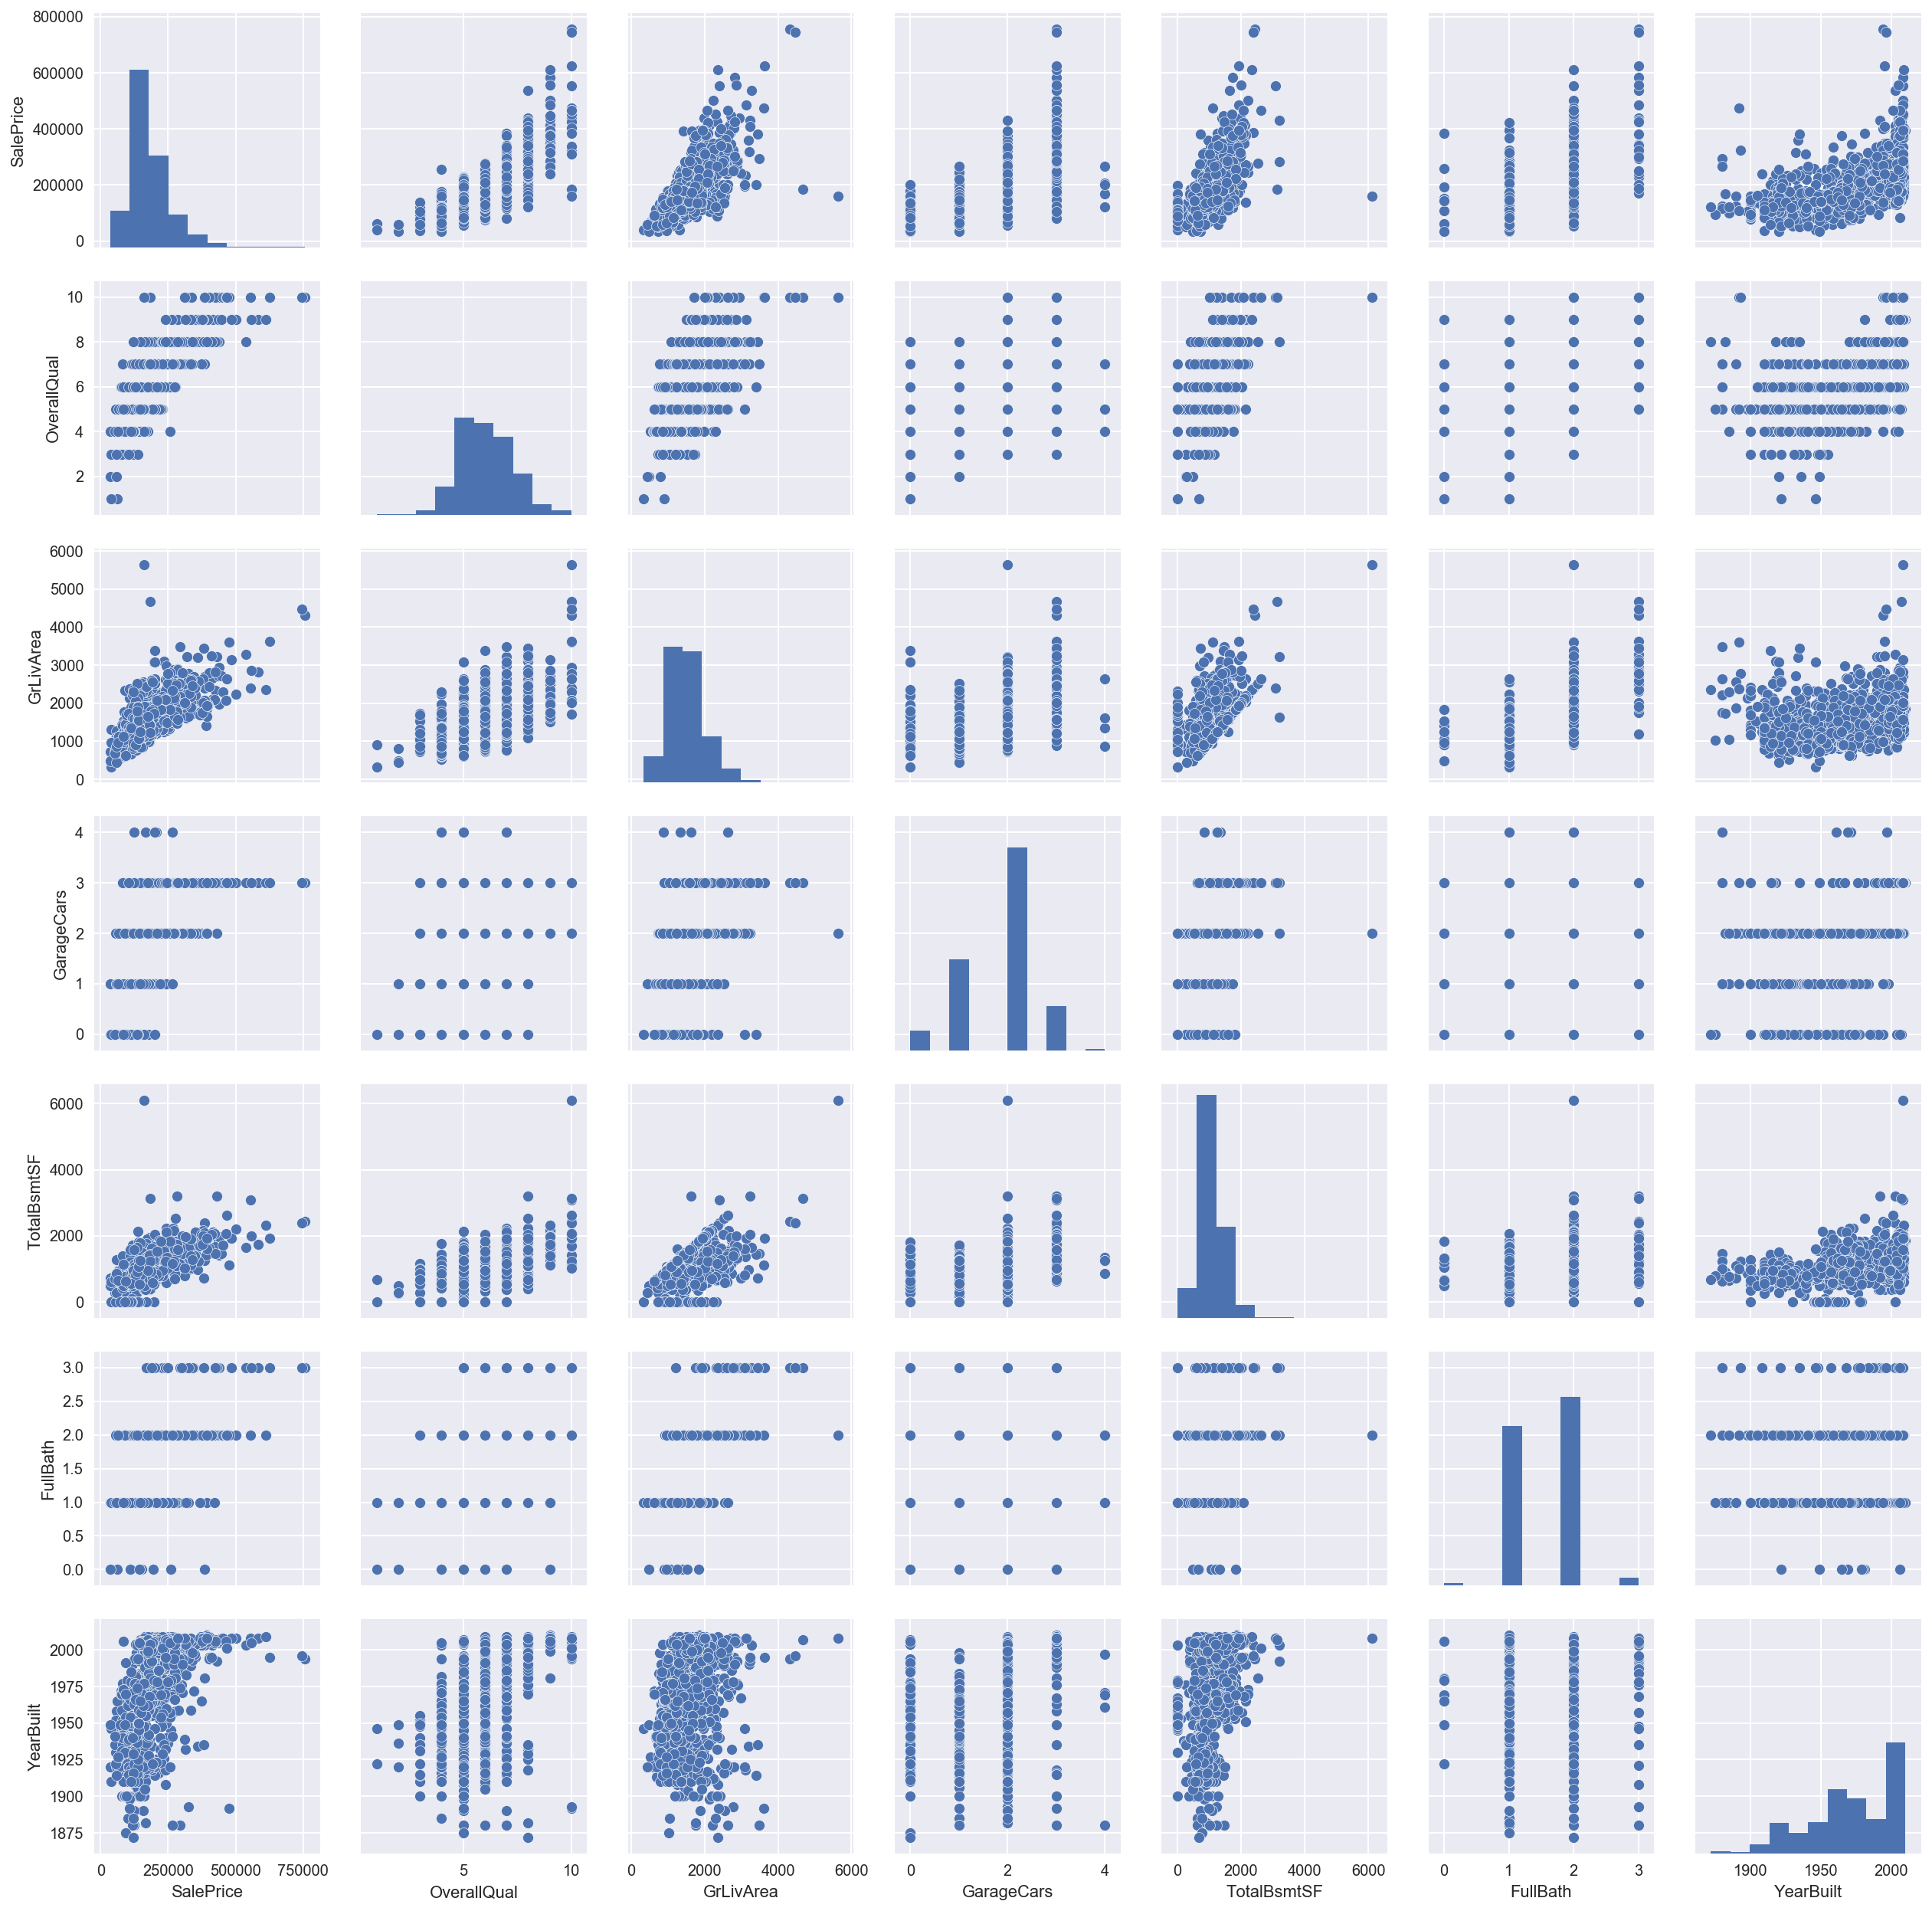

In [79]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show()

In [105]:
# Dividing the dataset into fixed and non-fixed

non_fixed = ['Utilities', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
             'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',  'Heating', 
             'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'FireplaceQu', 'GarageQual',
             'GarageCond', 'GarageFinish', 'PavedDrive', 'WoodDeckSF']

fixed = ['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape', 'LandContour', 
         'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 
         'YearRemodAdd', 'Foundation','BsmtFinSF1', 'BsmtFinSF2',
         'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
         'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 
          'GarageCars', 'GarageArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
         'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']

In [106]:
house.shape

(1385, 76)

In [107]:
# Creating new dataframe with fixed features only
ffdf = house[fixed]

In [108]:
ffdf.sample(10)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
90,20,RL,7200,Pave,Reg,Lvl,Inside,Gtl,NAmes,Norm,...,29,0,0,0,0,7,2006,WD,Normal,109900
425,60,RM,3378,Pave,Reg,HLS,Inside,Gtl,OldTown,Norm,...,0,126,0,0,0,9,2009,WD,Normal,135000
793,20,RL,9158,Pave,Reg,Lvl,Inside,Gtl,Somerst,Norm,...,130,0,0,0,0,6,2007,New,Partial,225000
1001,30,RL,5400,Pave,Reg,Lvl,Corner,Gtl,OldTown,Norm,...,20,94,0,0,0,1,2007,WD,Abnorml,86000
508,70,RM,9600,Pave,Reg,Lvl,Inside,Gtl,OldTown,Norm,...,0,116,0,0,0,10,2008,WD,Normal,161000
1173,50,RL,18030,Pave,IR1,Bnk,Inside,Gtl,ClearCr,Norm,...,0,0,0,0,0,3,2007,WD,Normal,200500
268,30,RM,6900,Pave,Reg,Lvl,Inside,Gtl,IDOTRR,Norm,...,25,0,0,0,0,2,2008,WD,Normal,120500
1170,80,RL,9880,Pave,Reg,Lvl,Inside,Gtl,Mitchel,Norm,...,0,0,0,0,0,7,2008,WD,Normal,171000
795,60,RL,8400,Pave,Reg,Lvl,Inside,Gtl,SawyerW,Norm,...,50,0,0,204,0,4,2010,WD,Normal,171000
261,60,RL,9588,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,...,148,0,0,0,0,11,2007,New,Partial,276000


In [109]:
# String columns among ffdf
strdf= ffdf.columns[ffdf.dtypes==object]
strdf

Index([u'MSZoning', u'Street', u'LotShape', u'LandContour', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'Foundation', u'Functional', u'SaleType',
       u'SaleCondition'],
      dtype='object')

In [110]:
# Coverting object datatype to numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in strdf:
    ffdf[i] = le.fit_transform(ffdf[i])
print ffdf.dtypes

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


MSSubClass       int64
MSZoning         int64
LotArea          int64
Street           int64
LotShape         int64
LandContour      int64
LotConfig        int64
LandSlope        int64
Neighborhood     int64
Condition1       int64
Condition2       int64
BldgType         int64
HouseStyle       int64
YearBuilt        int64
YearRemodAdd     int64
Foundation       int64
BsmtFinSF1       int64
BsmtFinSF2       int64
BsmtUnfSF        int64
TotalBsmtSF      int64
1stFlrSF         int64
2ndFlrSF         int64
GrLivArea        int64
BsmtFullBath     int64
BsmtHalfBath     int64
FullBath         int64
HalfBath         int64
BedroomAbvGr     int64
KitchenAbvGr     int64
TotRmsAbvGrd     int64
Functional       int64
Fireplaces       int64
GarageCars       int64
GarageArea       int64
OpenPorchSF      int64
EnclosedPorch    int64
3SsnPorch        int64
ScreenPorch      int64
MiscVal          int64
MoSold           int64
YrSold           int64
SaleType         int64
SaleCondition    int64
SalePrice  

In [111]:
numdf = ffdf.select_dtypes(include=np.number)
numdf.sample(10)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
553,20,1,8777,1,3,3,4,0,7,1,...,96,0,0,0,0,5,2009,8,4,108000
1343,50,1,7558,1,3,0,4,0,6,2,...,0,0,0,0,0,3,2009,8,4,177000
948,60,1,14006,1,0,3,4,0,5,2,...,96,0,0,0,0,2,2006,8,4,192500
1297,180,2,3675,1,3,3,4,0,7,2,...,44,0,0,0,0,6,2006,6,5,140000
22,20,1,9742,1,3,3,4,0,5,2,...,159,0,0,0,0,9,2008,8,4,230000
532,20,1,7200,1,3,3,4,0,12,2,...,0,0,0,0,0,4,2010,8,4,107500
796,20,1,8197,1,3,3,4,0,19,2,...,0,0,0,0,0,4,2007,8,4,143500
735,75,2,10800,1,3,3,4,0,17,2,...,341,0,0,0,0,10,2006,8,4,163000
298,60,1,11700,1,3,3,4,0,14,2,...,0,0,0,0,0,6,2007,8,4,175000
1136,50,1,9600,1,3,3,4,0,12,2,...,0,96,0,0,0,4,2008,8,0,119000


In [112]:
# Datatype is as per our requirement 
numdf.dtypes

MSSubClass       int64
MSZoning         int64
LotArea          int64
Street           int64
LotShape         int64
LandContour      int64
LotConfig        int64
LandSlope        int64
Neighborhood     int64
Condition1       int64
Condition2       int64
BldgType         int64
HouseStyle       int64
YearBuilt        int64
YearRemodAdd     int64
Foundation       int64
BsmtFinSF1       int64
BsmtFinSF2       int64
BsmtUnfSF        int64
TotalBsmtSF      int64
1stFlrSF         int64
2ndFlrSF         int64
GrLivArea        int64
BsmtFullBath     int64
BsmtHalfBath     int64
FullBath         int64
HalfBath         int64
BedroomAbvGr     int64
KitchenAbvGr     int64
TotRmsAbvGrd     int64
Functional       int64
Fireplaces       int64
GarageCars       int64
GarageArea       int64
OpenPorchSF      int64
EnclosedPorch    int64
3SsnPorch        int64
ScreenPorch      int64
MiscVal          int64
MoSold           int64
YrSold           int64
SaleType         int64
SaleCondition    int64
SalePrice  

In [113]:
#split by pre and post 2010
house_pre2010 = ffdf[ffdf['YrSold']< 2010]
house_post2010 = ffdf[ffdf['YrSold']> 2009]

In [114]:
train_house = house_pre2010
test_house = house_post2010

In [115]:
# X train/test and Y train/test data split 
from sklearn.preprocessing import StandardScaler

cols = list(train_house.columns)
cols.remove('SalePrice')

#Training Data:
X = pd.DataFrame(StandardScaler().fit_transform(train_house[cols]), columns =cols )
y = train_house['SalePrice'].values

# Test Data 
Test_X = pd.DataFrame(StandardScaler().fit_transform(test_house[cols]), columns =cols )
Test_y = test_house['SalePrice'].values

Feature Selection

In [116]:
# Find score using SelectKBest 
from sklearn.feature_selection import SelectKBest,f_classif

skb_f = SelectKBest(f_classif, k=10)

# Train the selector on the data.
skb_f.fit(X, y)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_)], 
                     index=['feature','f_classif']).T.sort_values('f_classif', ascending=False)
kbest

,feature,f_classif
38,MiscVal,3.85629
22,GrLivArea,3.38479
3,Street,3.2995
2,LotArea,3.28119
32,GarageCars,2.68758
25,FullBath,2.63483
33,GarageArea,2.53761
20,1stFlrSF,2.25453
19,TotalBsmtSF,2.199
13,YearBuilt,2.07012


In [117]:
#Recursive Feature Elimination (RFE)

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X, y)

print selector.support_
print selector.ranking_

[False False False False False False False False  True False False  True
 False  True  True False  True False False  True  True  True  True  True
 False  True False  True  True  True  True  True  True False False False
 False  True False False False False  True]
[18 13 10 11  8 12 16  2  1 24  4  1  3  1  1  9  1 25  7  1  1  1  1  1
  6  1  5  1  1  1  1  1  1 21 15 23 19  1 22 17 14 20  1]


In [118]:
# The column names correspond to the ones below. RFECV only excluded a few features.
rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

array(['Neighborhood', 'BldgType', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars',
       'ScreenPorch', 'SaleCondition'], dtype='|S13')

In [119]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
#optimal alpha Lasso model CV scores
optimal_lasso = LassoCV(n_alphas=500, cv=10) #LassoCV decide what alphas to use, just set no. of alphas to test.
optimal_lasso.fit(X, y)
print optimal_lasso.alpha_

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X, y, cv=10)
print lasso_scores
print np.mean(lasso_scores)

#Lasso feature selection/variable selection alternative
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso = lasso.fit(X, y)
lasso_coefs = pd.DataFrame({'Feature': X.columns,
                            'coef':lasso.coef_,
                           'abs_coef':np.abs(lasso.coef_)})


lasso_coefs.sort_values('abs_coef', ascending=False)


991.1458842169889
[0.84711031 0.81488349 0.84235549 0.70889803 0.77491344 0.78430414
 0.83131791 0.77395645 0.37260039 0.79709406]
0.7547433725018851


,Feature,abs_coef,coef
22,GrLivArea,34050.847834,34050.847834
32,GarageCars,11817.070043,11817.070043
13,YearBuilt,9276.779683,9276.779683
19,TotalBsmtSF,8997.515736,8997.515736
14,YearRemodAdd,8773.840387,8773.840387
27,BedroomAbvGr,7487.958986,-7487.958986
28,KitchenAbvGr,7024.246952,-7024.246952
30,Functional,6116.704752,6116.704752
31,Fireplaces,5278.117307,5278.117307
29,TotRmsAbvGrd,4808.731049,4808.731049


In [120]:
kbest_columns = kbest.feature.values[2:20]
lasso_columns = list(lasso_coefs[lasso_coefs.abs_coef > 0]['Feature'])

In [121]:
len(lasso_columns)

29

In [122]:
# optimal_lasso = LassoCV(n_alphas=500, cv=10) #LassoCV to decide what alpha to use
# optimal_lasso.fit(X, y)
# lasso = Lasso(alpha=optimal_lasso.alpha_)
import sklearn.linear_model as linear_model
lm = linear_model.LinearRegression()
# lm_scores = cross_val_score(lm, X, y, cv=10)

# Defining a function to test our best features
def score(X):
    lm_scores = cross_val_score(lm, X, y, cv=10)
    return lm_scores.mean(), lm_scores.std() 

# A list of all of our lists of best features being executed in the score function.
all_scores = [
    score(X[kbest_columns]),
    score(X[rfecv_columns]),
    score(X[lasso_columns]),
    score(X)]  
# Putting results into a DataFrame.

pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'lr', 'all'])

,mean score,std score
kbest,0.725199,0.140593
rfecv,0.760544,0.128448
lr,0.754821,0.135831
all,0.746329,0.135350


In [123]:
#Apply lasso
optimal_lasso = LassoCV(n_alphas=500, cv=10) #LassoCV to decide what alpha to use
optimal_lasso.fit(X[lasso_columns], y)
ls = Lasso(alpha = optimal_lasso.alpha_)

#10 cross-validation on lasso
lsscore = cross_val_score(ls, X[lasso_columns], y, cv= 10)
print '10 fold Training accuracy scores: ',lsscore, 'Mean: ', lsscore.mean()


#Performing the prediction
ls.fit(X[lasso_columns],y)
predictions_m1_test = ls.predict(Test_X[lasso_columns])
predictions_m1_train = ls.predict(X[lasso_columns])
#score of prediction
print 'Predicted R2 scores:', ls.score(Test_X[lasso_columns],Test_y)

10 fold Training accuracy scores:  [0.85153847 0.82408419 0.84990129 0.70484606 0.78314721 0.79083128
 0.81809537 0.77982417 0.36734999 0.78908972] Mean:  0.7558707775362978
Predicted R2 scores: 0.8299206900181242


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [124]:
nfdf = house[non_fixed]

In [126]:
nfdf = pd.concat([nfdf, house[['YrSold', 'SalePrice']]], axis=1)

In [127]:
nfdf.sample(10)

,Utilities,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,...,LowQualFinSF,KitchenQual,FireplaceQu,GarageQual,GarageCond,GarageFinish,PavedDrive,WoodDeckSF,YrSold,SalePrice
1151,AllPub,5,4,Gable,CompShg,HdBoard,Plywood,BrkFace,132.0,TA,...,0,Fa,Gd,TA,TA,Fin,Y,0,2006,149900
583,AllPub,10,9,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Ex,...,0,Gd,Gd,Gd,TA,Unf,Y,105,2008,325000
1352,AllPub,6,9,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,...,0,TA,No_Fireplce,TA,TA,Unf,N,210,2009,134900
634,AllPub,6,5,Gable,CompShg,Plywood,Plywood,None,0.0,TA,...,0,TA,No_Fireplce,TA,TA,Unf,Y,264,2010,144000
1446,AllPub,5,7,Gable,CompShg,HdBoard,HdBoard,BrkFace,189.0,TA,...,0,TA,No_Fireplce,TA,TA,Unf,P,261,2010,157900
496,AllPub,8,5,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,...,0,Gd,Gd,TA,TA,RFn,Y,264,2007,430000
1263,AllPub,6,6,Gambrel,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,...,0,TA,Gd,TA,TA,Unf,N,0,2007,180500
490,AllPub,5,6,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,...,0,TA,Gd,TA,TA,Fin,Y,141,2008,115000
168,AllPub,7,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,...,0,Gd,Gd,TA,TA,Fin,Y,100,2007,183500
1143,AllPub,5,3,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,...,0,TA,No_Fireplce,No_Garage,No_Garage,No_Garage,Y,0,2008,80000


In [130]:
nfdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 27 columns):
Utilities       1385 non-null object
OverallQual     1385 non-null int64
OverallCond     1385 non-null int64
RoofStyle       1385 non-null object
RoofMatl        1385 non-null object
Exterior1st     1385 non-null object
Exterior2nd     1385 non-null object
MasVnrType      1385 non-null object
MasVnrArea      1385 non-null float64
ExterQual       1385 non-null object
ExterCond       1385 non-null object
BsmtQual        1385 non-null object
BsmtCond        1385 non-null object
Heating         1385 non-null object
HeatingQC       1385 non-null object
CentralAir      1385 non-null object
Electrical      1385 non-null object
LowQualFinSF    1385 non-null int64
KitchenQual     1385 non-null object
FireplaceQu     1385 non-null object
GarageQual      1385 non-null object
GarageCond      1385 non-null object
GarageFinish    1385 non-null object
PavedDrive      1385 non-null object
WoodDec

In [129]:
# Checking for null values
nfdf.isnull().sum()

Utilities       0
OverallQual     0
OverallCond     0
RoofStyle       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
ExterQual       0
ExterCond       0
BsmtQual        0
BsmtCond        0
Heating         0
HeatingQC       0
CentralAir      0
Electrical      0
LowQualFinSF    0
KitchenQual     0
FireplaceQu     0
GarageQual      0
GarageCond      0
GarageFinish    0
PavedDrive      0
WoodDeckSF      0
YrSold          0
SalePrice       0
dtype: int64

In [131]:
# Object columns
str_cols = nfdf.columns[nfdf.dtypes==object]
str_cols

Index([u'Utilities', u'RoofStyle', u'RoofMatl', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'ExterQual', u'ExterCond', u'BsmtQual', u'BsmtCond',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'FireplaceQu', u'GarageQual', u'GarageCond', u'GarageFinish',
       u'PavedDrive'],
      dtype='object')

In [132]:
#Converting categorical to numerical variables

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in str_cols:
    nfdf[i] = le.fit_transform(nfdf[i])
print nfdf.dtypes

Utilities         int64
OverallQual       int64
OverallCond       int64
RoofStyle         int64
RoofMatl          int64
Exterior1st       int64
Exterior2nd       int64
MasVnrType        int64
MasVnrArea      float64
ExterQual         int64
ExterCond         int64
BsmtQual          int64
BsmtCond          int64
Heating           int64
HeatingQC         int64
CentralAir        int64
Electrical        int64
LowQualFinSF      int64
KitchenQual       int64
FireplaceQu       int64
GarageQual        int64
GarageCond        int64
GarageFinish      int64
PavedDrive        int64
WoodDeckSF        int64
YrSold            int64
SalePrice         int64
dtype: object


In [133]:
nfdf.shape

(1385, 27)

In [134]:
#split by pre and post 2010
house_pre2010_nonfix = nfdf[nfdf['YrSold']< 2010]
house_post2010_nonfix = nfdf[nfdf['YrSold']> 2009]

In [135]:
train_house_nonfix = house_pre2010_nonfix
print train_house_nonfix.shape
test_house_nonfix = house_post2010_nonfix
print test_house_nonfix.shape


(1221, 27)
(164, 27)


In [136]:
# Split to X train/test and Y train/test
from sklearn.preprocessing import StandardScaler

cols = list(train_house_nonfix.columns)
cols.remove('SalePrice')

#Training Data
X1 = pd.DataFrame(StandardScaler().fit_transform(train_house_nonfix[cols]), columns =cols )
y1 = train_house_nonfix['SalePrice'].values

# Test Data 
Test_X1 = pd.DataFrame(StandardScaler().fit_transform(test_house_nonfix[cols]), columns =cols )
Test_y1 = test_house_nonfix['SalePrice'].values

In [137]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
#optimal alpha Lasso model CV scores
optimal_lasso_nonfix = LassoCV(n_alphas=500, cv=10) #LassoCV to decide alpha
optimal_lasso_nonfix.fit(X1, y1)
print optimal_lasso_nonfix.alpha_

lasso_nonfix = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores_nonfix = cross_val_score(lasso_nonfix, X1, y1, cv=10)
print lasso_scores_nonfix
print np.mean(lasso_scores_nonfix)

#Lasso feature selection alternative
lasso_nonfix = Lasso(alpha=optimal_lasso.alpha_)
lasso_nonfix = lasso_nonfix.fit(X1, y1)
lasso_coefs_nonfix = pd.DataFrame({'Feature': X1.columns,
                            'coef':lasso_nonfix.coef_,
                           'abs_coef':np.abs(lasso_nonfix.coef_)})


lasso_coefs_nonfix.sort_values('coef', ascending=False,inplace = True)
lasso_coefs_nonfix

673.6782387010674
[0.77720684 0.74511854 0.73022629 0.66799609 0.75593352 0.73573439
 0.70951277 0.70213713 0.59970494 0.7524296 ]
0.7176000115885321


,Feature,abs_coef,coef
1,OverallQual,34899.105684,34899.105684
8,MasVnrArea,13509.052052,13509.052052
24,WoodDeckSF,6994.137680,6994.137680
4,RoofMatl,6440.900859,6440.900859
7,MasVnrType,4563.992636,4563.992636
3,RoofStyle,4214.881451,4214.881451
2,OverallCond,3145.206361,3145.206361
21,GarageCond,3027.458312,3027.458312
23,PavedDrive,2522.937020,2522.937020
15,CentralAir,1447.967377,1447.967377


In [139]:
# lasso columns
lasso_columns1 = list(lasso_coefs_nonfix[lasso_coefs_nonfix.abs_coef > 0]['Feature'])

In [140]:
# Elimating features which are not statistically significant
import statsmodels.api as sm

model = sm.OLS(y1, X1[lasso_columns1])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     6.243
Date:                Sat, 14 Jul 2018   Prob (F-statistic):           4.37e-20
Time:                        17:53:11   Log-Likelihood:                -16542.
No. Observations:                1221   AIC:                         3.314e+04
Df Residuals:                    1195   BIC:                         3.327e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual   3.466e+04   8541.800      4.057   

In [141]:
# Residual values to determine new y to test with non-fixed features.


y_var_test = Test_y- predictions_m1_test
y_var_train = y - predictions_m1_train

In [142]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
#optimal alpha Lasso model CV scores
optimal_lasso_var = LassoCV(n_alphas=500, cv=10) #LassoCV to decide what alpha to use
optimal_lasso_var.fit(X1, y_var_train)
print optimal_lasso_var.alpha_

lasso_var = Lasso(alpha=optimal_lasso_var.alpha_)
lasso_scores_var = cross_val_score(lasso_var, X1, y_var_train, cv=10)
print lasso_scores_var
print np.mean(lasso_scores_var)

#Lasso feature selection alternative
lasso_var = lasso_var.fit(X1, y_var_train)
lasso_coefs_var = pd.DataFrame({'Feature': X1.columns,
                            'coef':lasso_var.coef_,
                           'abs_coef':np.abs(lasso_var.coef_)})

lasso_coefs_var.sort_values('coef', ascending=False,inplace = True)
lasso_coefs_var

289.52374986261617
[ 0.21219383  0.21198795  0.2898591  -0.11864581  0.24936992  0.2271213
 -0.10160827  0.17858297 -0.04236142  0.2165986 ]
0.13230981737922026


,Feature,abs_coef,coef
2,OverallCond,5308.947048,5308.947048
1,OverallQual,3104.139829,3104.139829
8,MasVnrArea,2781.014934,2781.014934
4,RoofMatl,2742.495073,2742.495073
7,MasVnrType,1450.118091,1450.118091
3,RoofStyle,1081.993915,1081.993915
12,BsmtCond,1011.955186,1011.955186
14,HeatingQC,619.201028,619.201028
24,WoodDeckSF,524.307530,524.307530
13,Heating,0.000000,-0.000000


In [143]:
lasso_columns = list(lasso_coefs_var[lasso_coefs_var.abs_coef > 0]['Feature'])

In [144]:
#Performing the prediction
ls.fit(X1[lasso_columns],y_var_train)
prediction = ls.predict(Test_X1[lasso_columns])
#Getting the score of prediction
print 'Predicted R2 scores:', ls.score(Test_X1[lasso_columns],y_var_test)

Predicted R2 scores: 0.2129830294712255


A low R2 suggests that non-fixed features are not related to residuals.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: